In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
from math import factorial

In [20]:
sns.set(
    style = 'whitegrid',
    rc={'figure.figsize':(12,7)}
)

In [4]:
# Подключимся к базе данных ClickHouse
connection = {'host': 'https://clickhouse.lab.karpov.courses/',
              'database':'default',
              'user':'student', 
              'password':'dpo_python_2020'}

In [31]:
# Для начала, проверим правильность подключения к ClickHouse через pandahouse, 
# отправив простой запрос: выведите количество строк в таблице ldn_listings.
query = '''
SELECT 
    COUNT(*)
FROM 
    ldn_listings  
'''

In [32]:
df = ph.read_clickhouse(query=query, connection=connection)

In [33]:
df

,count()
0,85207


Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

price – цена за ночь
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Пример результирующей таблицы:

| room_type       | price      |
|-----------------|------------|
| Private room    |         65 | 
| Entire home/apt |        100 | 

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [34]:
query_2 = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM 
    ldn_listings 
ORDER BY
    id ASC
LIMIT 1000
'''

In [35]:
df_2 = ph.read_clickhouse(query=query_2, connection=connection) 

In [36]:
df_2

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [37]:
df_2.groupby('room_type', as_index=False).quantile(q=0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

Исходная таблица должна выглядеть так:

| room_type       | price      |review_scores_rating|
|-----------------|------------|--------------------|
| Private room    |         65 | 96.0               |
| Entire home/apt |        100 | 78.0               |

1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

In [38]:
query_3 = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM 
    ldn_listings
WHERE 
    review_scores_rating IS NOT NULL
ORDER BY
    id ASC
LIMIT 1000
'''

In [39]:
df_3 = ph.read_clickhouse(query=query_3, connection=connection)

In [40]:
df_3.head()

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [41]:
avg_price_and_rating = df_3.groupby('room_type', as_index=False).mean()

In [42]:
avg_price_and_rating

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


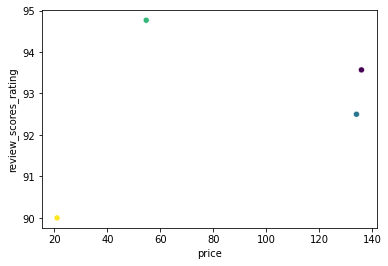

In [43]:
sns.scatterplot(data='avg_price_and_rating', x=avg_price_and_rating.price, y=avg_price_and_rating.review_scores_rating)

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления. Для каждого уникального пользователя выгрузите только две колонки:

host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль
Затем обработайте столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']

2. Посчитайте, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [110]:
query_4 = '''
SELECT 
    DISTINCT host_id,
    host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
'''

In [111]:
df_4 = ph.read_clickhouse(query=query_4, connection=connection)

In [112]:
rem_chars = ['[', ']', "'"]
for i in rem_chars:
    df_4.host_verifications = df_4.host_verifications.apply(lambda x: x.replace(i, ""))
df_4.host_verifications = df_4.host_verifications.apply(lambda x: x.split(', '))

In [113]:
df_4 = df_4.explode('host_verifications')

In [114]:
df_4.groupby('host_verifications') \
    .agg({'host_id': 'count'})

,host_id
host_verifications,
email,1345
facebook,270
google,34
government_id,1196
identity_manual,227
jumio,1115
kba,27
manual_offline,70
manual_online,16


Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

| neighbourhood_cleansed | experiences_offered | experiences_count |
|------------------------|---------------------|-------------------|
| City of London         | business            |                 7 |
| City of London         | family              |                 1 |
| City of London         | romantic            |                 1 |

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

Какой график получился?

In [125]:
query_5 = '''
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(id) AS experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed,
    experiences_offered
ORDER BY  
    experiences_count DESC
LIMIT 100 
'''

In [126]:
df_5 = ph.read_clickhouse(query_5,connection=connection)

In [127]:
df_5.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [129]:
adds_by_area = df_5.pivot(index='neighbourhood_cleansed', columns='experiences_offered',values='experiences_count')

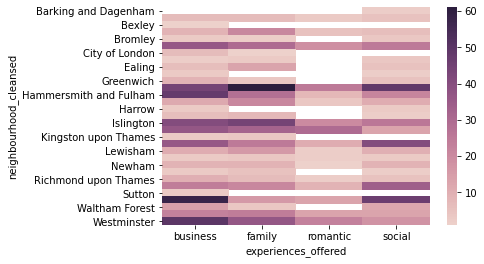

In [130]:
sns.heatmap(data=adds_by_area, cmap=sns.cubehelix_palette(as_cmap=True))

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')
Пример части результирующей таблицы:

| room_type       | price_corr |
|-----------------|------------|
| Private room    |         65 |
| Entire home/apt |        100 |
| Entire home/apt |        ... |

Далее постройте два графика, используя distplot из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

In [2]:
query_6 = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_corr
FROM 
    ldn_listings 
WHERE
    experiences_offered != 'none'
'''

In [5]:
df_6 = ph.read_clickhouse(query=query_6, connection=connection)

In [6]:
df_6

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


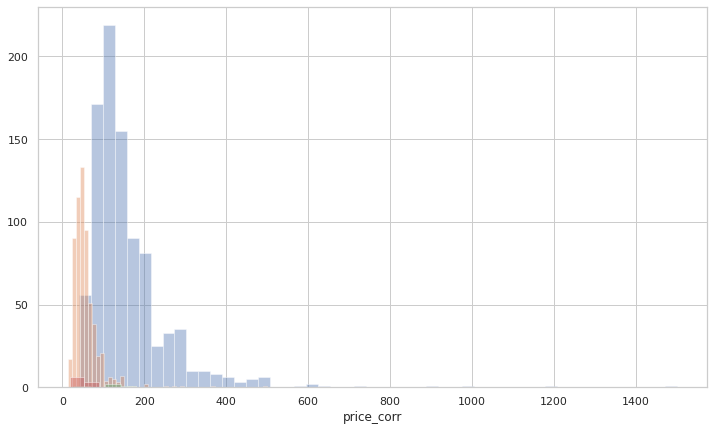

In [25]:
sns.distplot(df_6[df_6.room_type == 'Entire home/apt'].price_corr, kde=False)
sns.distplot(df_6[df_6.room_type == 'Private room'].price_corr, kde=False)
sns.distplot(df_6[df_6.room_type == 'Hotel room'].price_corr, kde=False)
sns.distplot(df_6[df_6.room_type == 'Shared room'].price_corr, kde=False)

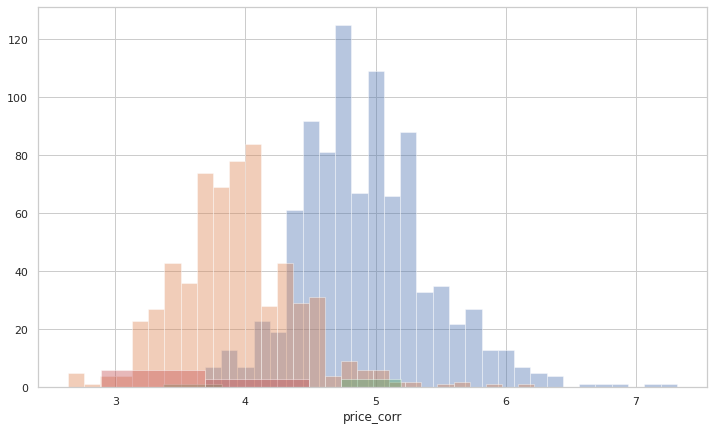

In [26]:
sns.distplot(np.log(df_6[df_6.room_type == 'Entire home/apt'].price_corr), kde=False)
sns.distplot(np.log(df_6[df_6.room_type == 'Private room'].price_corr), kde=False)
sns.distplot(np.log(df_6[df_6.room_type == 'Hotel room'].price_corr), kde=False)
sns.distplot(np.log(df_6[df_6.room_type == 'Shared room'].price_corr), kde=False)

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.

Пример результирующей таблицы:

| room_type       | price_corr |first_review|
|-----------------|------------|------------|
| Private room    |         65 | 2010-03-23 |
| Entire home/apt |        100 | 2012-01-01 |

Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

Пример датафрейма, который будет служить основой для графика:

| room_type       | avg_price  | year       |
|-----------------|------------|------------|
| Private room    |         54 | 2010       |
| Entire home/apt |        168 | 2012       |

In [47]:
query_7 = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toDateOrZero(first_review) AS first_review
FROM 
    ldn_listings
WHERE 
    first_review > '2010-01-01'
LIMIT 1000
'''

In [48]:
df_7 = ph.read_clickhouse(query=query_7, connection=connection)

In [55]:
df_7.first_review = df_7.first_review.dt.year

In [64]:
price_by_year = df_7.groupby(['room_type','first_review'], as_index=False) \
    .agg({'price': 'mean'}) \
    .sort_values('first_review')

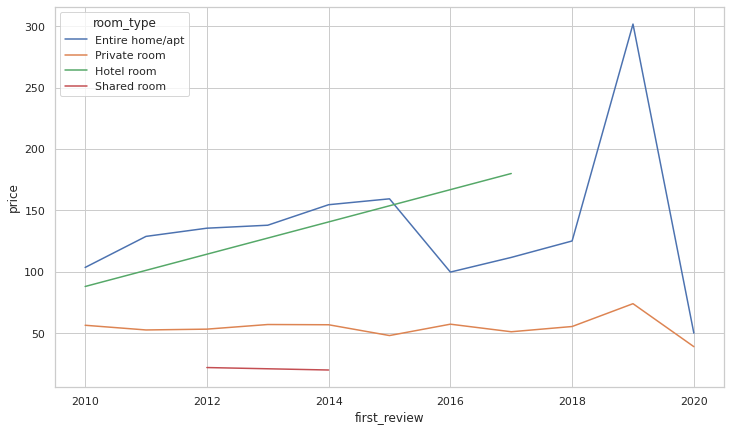

In [65]:
sns.lineplot(data=price_by_year, x=price_by_year.first_review, y=price_by_year.price, hue=price_by_year.room_type)